# Preliminary Look and Clustering News Sources

Junita Sirait

I would like to cluster news sources after applying dimensionality reduction or feature extraction using Principle Component Analysis PCA.

In [1]:
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn import preprocessing

from sklearn.metrics import silhouette_score
from kneed import KneeLocator

from scipy.interpolate import make_interp_spline, BSpline

from sklearn.decomposition import PCA

In [2]:
with open("ns_subreddit_2021-01.json", "r", encoding = "utf-8") as infile:
    ns_subreddit = json.load(infile)

How many news sources are there?

In [3]:
num_ns = len(ns_subreddit)
num_ns

3684

Let's see the data structure for `nytimes.com`

In [4]:
Counter(ns_subreddit['nytimes.com']).most_common(20)

[('nytimes', 5635),
 ('NYTauto', 3903),
 ('AutoNewspaper', 3871),
 ('politics', 2059),
 ('TrendingQuickTVnews', 1461),
 ('news', 679),
 ('u_NumerousRow', 640),
 ('NewsWhatever', 319),
 ('Coronavirus', 267),
 ('worldnews', 243),
 ('u_Music908', 233),
 ('FreshNewsToday', 228),
 ('u_somuchinfook', 216),
 ('ScienceFeed', 187),
 ('NoFilterNews', 170),
 ('neoliberal', 159),
 ('u_CostBenKMA', 153),
 ('autotldr', 118),
 ('badgovnofreedom', 117),
 ('WTFJustHappenedToday', 108)]

For each news source, let's count in how many subreddits they appear

In [5]:
subreddit_count = dict()
for ns in ns_subreddit:
    subreddit_count[ns] = len(ns_subreddit[ns].keys())

`subreddit_count` stores in how many subreddits each news source appears.

In [6]:
subreddit_count['nytimes.com']

2198

In [7]:
subreddit_count_freq = dict(Counter(subreddit_count.values()).most_common())
subreddit_count_freq

{1: 696,
 2: 412,
 3: 305,
 4: 251,
 5: 165,
 6: 152,
 7: 125,
 9: 94,
 8: 87,
 10: 74,
 11: 69,
 12: 64,
 14: 62,
 13: 52,
 17: 46,
 16: 43,
 19: 39,
 15: 39,
 18: 37,
 22: 34,
 20: 32,
 21: 26,
 25: 26,
 29: 24,
 27: 24,
 33: 23,
 24: 20,
 31: 20,
 26: 19,
 36: 18,
 23: 18,
 34: 17,
 30: 17,
 32: 16,
 35: 14,
 28: 14,
 39: 13,
 43: 12,
 37: 11,
 45: 11,
 40: 11,
 47: 10,
 68: 9,
 38: 9,
 55: 9,
 42: 9,
 77: 9,
 71: 8,
 48: 8,
 59: 8,
 58: 7,
 57: 7,
 46: 7,
 54: 7,
 73: 7,
 50: 7,
 112: 6,
 65: 6,
 64: 6,
 66: 6,
 56: 6,
 53: 6,
 69: 6,
 52: 5,
 105: 5,
 60: 5,
 63: 5,
 79: 5,
 93: 4,
 103: 4,
 67: 4,
 62: 4,
 51: 4,
 41: 4,
 85: 4,
 91: 4,
 95: 3,
 107: 3,
 209: 3,
 78: 3,
 74: 3,
 108: 3,
 115: 3,
 116: 3,
 44: 3,
 100: 3,
 89: 3,
 87: 3,
 111: 3,
 126: 3,
 90: 3,
 86: 3,
 83: 3,
 96: 3,
 70: 3,
 114: 3,
 97: 2,
 256: 2,
 248: 2,
 463: 2,
 98: 2,
 196: 2,
 150: 2,
 289: 2,
 156: 2,
 61: 2,
 136: 2,
 133: 2,
 94: 2,
 158: 2,
 134: 2,
 155: 2,
 125: 2,
 213: 2,
 206: 2,
 132: 2,
 75:

`subreddit_count_freq` keeps track of how many news sources appear in *n* subreddits for all possible *n*.

In [8]:
max(subreddit_count_freq.keys())

2198

Wow! There is a news source that appears in 2174 subreddits. This is `nytimes.com`.

In [9]:
for ns in ns_subreddit:
    count = subreddit_count[ns]
    if count > 1000:
        print(f"{ns} appears in {count} subreddits.")

reuters.com appears in 1485 subreddits.
cnn.com appears in 1666 subreddits.
cnbc.com appears in 1266 subreddits.
apnews.com appears in 1415 subreddits.
nytimes.com appears in 2198 subreddits.
bbc.co.uk appears in 1044 subreddits.
nbcnews.com appears in 1041 subreddits.
washingtonpost.com appears in 1492 subreddits.
independent.co.uk appears in 1102 subreddits.
linkedin.com appears in 1274 subreddits.


Not sure why `cnbc.com` appears in so many subreddits. Canada! Linkedin appears a lot too, people sharing about themselves? But anonymous?

## Cluster Try Out

First, I make a list of subreddits with fixed order.

In [10]:
with open("subreddit_ns_2021-01.json", "r", encoding = "utf-8") as infile:
    subreddit_ns = json.load(infile)

In [11]:
subreddits = list(subreddit_ns.keys())
len(subreddits)

19153

There are 19153 subreddits in January 2021.

In [12]:
subreddits[:10]

['razorbacks',
 'realtech',
 'chile',
 'Teachers',
 'CollegeBasketball',
 'NewsWithoutNewsMedia',
 'BravoRealHousewives',
 'anime',
 'nycrail',
 'autotldr']

If I should order them later, I can do so.

Then, for each news source, I create a list of length 20755 (# subreddits), and the values would be the count of how many times that news source appears in subreddit index *i*, where the index is based on the list `subreddits`.

In [14]:
ns_sr_rep = dict()
for ns in ns_subreddit:
    ns_sr_rep[ns] = [ns_subreddit[ns][subreddits[idx]] if subreddits[idx] in ns_subreddit[ns] else 0 for idx in range(len(subreddits))]

Let's see one example of representation for `nytimes.com`.

In [28]:
ns_sr_rep['nytimes.com']

[0,
 17,
 0,
 5,
 0,
 4,
 10,
 0,
 5,
 118,
 267,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 2059,
 679,
 1,
 16,
 1,
 18,
 8,
 0,
 1,
 0,
 0,
 20,
 3903,
 7,
 0,
 7,
 0,
 0,
 0,
 1,
 3871,
 1,
 83,
 8,
 0,
 0,
 1461,
 7,
 28,
 0,
 0,
 6,
 0,
 12,
 13,
 0,
 159,
 0,
 0,
 87,
 0,
 0,
 1,
 13,
 0,
 0,
 0,
 0,
 36,
 14,
 216,
 5,
 0,
 7,
 2,
 1,
 45,
 0,
 0,
 28,
 0,
 0,
 0,
 0,
 5,
 23,
 5,
 2,
 21,
 3,
 3,
 0,
 0,
 24,
 3,
 1,
 0,
 0,
 0,
 0,
 19,
 16,
 0,
 1,
 6,
 61,
 0,
 0,
 0,
 0,
 0,
 243,
 39,
 2,
 8,
 11,
 6,
 0,
 0,
 0,
 0,
 0,
 92,
 3,
 33,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 72,
 1,
 0,
 0,
 0,
 0,
 108,
 0,
 0,
 57,
 1,
 0,
 8,
 80,
 7,
 8,
 228,
 24,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 33,
 0,
 0,
 0,
 0,
 0,
 319,
 170,
 0,
 2,
 10,
 0,
 2,
 117,
 15,
 2,
 1,
 0,
 0,
 0,
 6,
 0,
 7,
 0,
 1,
 71,
 0,
 0,
 0,
 0,
 0,
 0,
 640,
 2,
 1,
 1,
 5,
 0,
 2,
 0,
 63,
 21,
 0,
 3,
 0,
 1,
 0,
 0,
 1,
 1,
 9,
 13,


**Now I will normalize each feature to be in the range of 0 and 1.**

In [15]:
items = list(ns_sr_rep.items())

In [16]:
ns_repr, ns_fixed = np.array([v[1] for v in items]), list([v[0] for v in items])

In [17]:
minmax = MinMaxScaler(feature_range=(0, 1))
ns_repr = minmax.fit_transform(ns_repr)
# n_scaled = preprocessing.scale(X)

In [31]:
ns_fixed[0]

'espn.com'

In [30]:
from collections import Counter
Counter(list(ns_repr[0]))

Counter({1.0: 207,
         0.0: 18712,
         0.00273224043715847: 1,
         0.017142857142857144: 1,
         0.008064516129032258: 1,
         0.0027195027195027195: 1,
         0.014059753954305799: 1,
         0.0009541984732824427: 1,
         0.1484915378955114: 1,
         0.10344827586206896: 1,
         0.045454545454545456: 2,
         0.006289308176100629: 1,
         0.0037735849056603774: 1,
         0.04838709677419355: 1,
         0.004608294930875576: 1,
         0.0017730496453900709: 1,
         0.005578093306288032: 1,
         0.3333333333333333: 17,
         0.152: 1,
         0.0014705882352941176: 1,
         0.05454545454545454: 1,
         0.02857142857142857: 3,
         0.004687500000000001: 1,
         0.2553191489361702: 1,
         0.008403361344537815: 1,
         0.2464589235127479: 1,
         0.047619047619047616: 2,
         0.0016927634363097758: 1,
         0.005221932114882507: 1,
         0.2: 8,
         0.043478260869565216: 2,
         0.1

In [20]:
len(ns_repr[0])

19153

In [32]:
len(ns_repr)

3684

## Dimensionality Reduction using PCA

In [22]:
pca = PCA()
pca_d = pca.fit_transform(ns_repr)
explained_var = pca.explained_variance_ratio_

In [23]:
explained_var[:10]

array([0.05625637, 0.03380122, 0.02516885, 0.02231908, 0.01969598,
       0.01705472, 0.0167236 , 0.01617491, 0.01541978, 0.01303218])

In [24]:
explained_var_sums = [sum(explained_var[:d]) for d in range(len(ns_repr))]

In [25]:
kl = KneeLocator(range(len(explained_var_sums)), explained_var_sums, curve="concave", direction="increasing")
kl.find_knee()

(559, 0.15177844148791747)

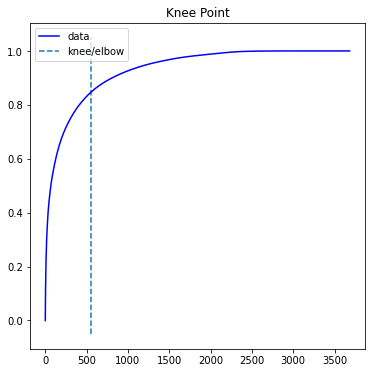

In [26]:
kl.plot_knee()

## Now we know to reduce to 559 features

In [27]:
pca_559 = PCA(n_components=559)
ns_repr_559 = pca_559.fit_transform(ns_repr)

## Next, we cluster

First we need to find the appropriate number of clusters

In [90]:
# Elbow method
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 56789432
}

In [91]:
sse = []
for k in range(1,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr_559)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 1 rounds, current sse is [26752.670851868097]
have done 2 rounds, current sse is [26752.670851868097, 25614.079567043293]
have done 3 rounds, current sse is [26752.670851868097, 25614.079567043293, 24963.790034344533]
have done 4 rounds, current sse is [26752.670851868097, 25614.079567043293, 24963.790034344533, 23896.260590980386]
have done 5 rounds, current sse is [26752.670851868097, 25614.079567043293, 24963.790034344533, 23896.260590980386, 23884.898008435983]
have done 6 rounds, current sse is [26752.670851868097, 25614.079567043293, 24963.790034344533, 23896.260590980386, 23884.898008435983, 22996.43373141728]
have done 7 rounds, current sse is [26752.670851868097, 25614.079567043293, 24963.790034344533, 23896.260590980386, 23884.898008435983, 22996.43373141728, 22360.600277860096]
have done 8 rounds, current sse is [26752.670851868097, 25614.079567043293, 24963.790034344533, 23896.260590980386, 23884.898008435983, 22996.43373141728, 22360.600277860096, 21665.521535668

have done 28 rounds, current sse is [26752.670851868097, 25614.079567043293, 24963.790034344533, 23896.260590980386, 23884.898008435983, 22996.43373141728, 22360.600277860096, 21665.521535668195, 21435.412856690586, 21446.283114066366, 20880.467610261156, 19832.152797479568, 19375.189632085825, 19375.077193571997, 18647.32209312329, 18529.87566691729, 18365.954765438266, 18595.795895880394, 17750.520930698876, 17560.950539733214, 17184.01340635496, 17048.045863329527, 16709.18718188435, 16739.448256100997, 16520.722851587452, 16251.552293382534, 16210.263392282026, 15986.120380762179]
have done 29 rounds, current sse is [26752.670851868097, 25614.079567043293, 24963.790034344533, 23896.260590980386, 23884.898008435983, 22996.43373141728, 22360.600277860096, 21665.521535668195, 21435.412856690586, 21446.283114066366, 20880.467610261156, 19832.152797479568, 19375.189632085825, 19375.077193571997, 18647.32209312329, 18529.87566691729, 18365.954765438266, 18595.795895880394, 17750.52093069

have done 40 rounds, current sse is [26752.670851868097, 25614.079567043293, 24963.790034344533, 23896.260590980386, 23884.898008435983, 22996.43373141728, 22360.600277860096, 21665.521535668195, 21435.412856690586, 21446.283114066366, 20880.467610261156, 19832.152797479568, 19375.189632085825, 19375.077193571997, 18647.32209312329, 18529.87566691729, 18365.954765438266, 18595.795895880394, 17750.520930698876, 17560.950539733214, 17184.01340635496, 17048.045863329527, 16709.18718188435, 16739.448256100997, 16520.722851587452, 16251.552293382534, 16210.263392282026, 15986.120380762179, 15922.75185274578, 15569.89371100352, 15476.350000161643, 15282.677077769145, 15240.144190168496, 14949.217131889945, 14807.296403796929, 14601.841834431112, 14670.138113993586, 14415.836169597933, 14302.825207249543, 14141.57544039262]
have done 41 rounds, current sse is [26752.670851868097, 25614.079567043293, 24963.790034344533, 23896.260590980386, 23884.898008435983, 22996.43373141728, 22360.600277860

have done 50 rounds, current sse is [26752.670851868097, 25614.079567043293, 24963.790034344533, 23896.260590980386, 23884.898008435983, 22996.43373141728, 22360.600277860096, 21665.521535668195, 21435.412856690586, 21446.283114066366, 20880.467610261156, 19832.152797479568, 19375.189632085825, 19375.077193571997, 18647.32209312329, 18529.87566691729, 18365.954765438266, 18595.795895880394, 17750.520930698876, 17560.950539733214, 17184.01340635496, 17048.045863329527, 16709.18718188435, 16739.448256100997, 16520.722851587452, 16251.552293382534, 16210.263392282026, 15986.120380762179, 15922.75185274578, 15569.89371100352, 15476.350000161643, 15282.677077769145, 15240.144190168496, 14949.217131889945, 14807.296403796929, 14601.841834431112, 14670.138113993586, 14415.836169597933, 14302.825207249543, 14141.57544039262, 13955.1090715928, 13922.024722977569, 13797.118694580886, 13700.771907621001, 13657.322379927076, 13485.05657816438, 13492.143483401966, 13482.770721915333, 13153.32120134

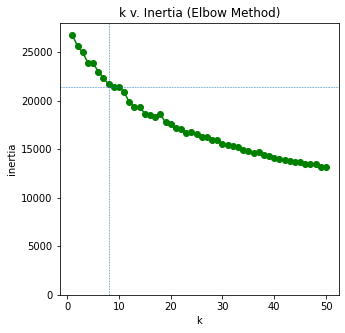

In [103]:
plt.figure(figsize=(5, 5)) #, dpi=80)
plt.plot(range(1,51),sse,"go-")
plt.ylim([0,28000])
plt.title("k v. Inertia (Elbow Method)")
plt.ylabel("inertia")
plt.xlabel("k")
plt.axvline(x=8, linestyle='--', linewidth = 0.5)
plt.axhline(y=sse[8], linestyle='--', linewidth = 0.5)

In [101]:
len(sse)

50

In [102]:
kl = KneeLocator(range(1,51), sse, curve="convex", direction="decreasing")
kl.elbow

8

### Using Silhouette Coefficient

In [105]:
sc = []
new_sse = []
for k in range(2,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr_559)
    score = silhouette_score(ns_repr_559, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50


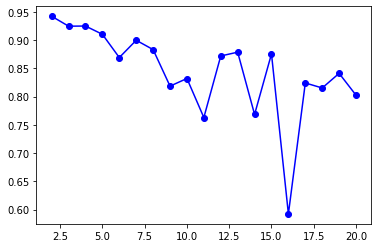

In [106]:
# for silhouette coefficient
plt.plot(range(2,21), sc[:19], "bo-")

## Clusters

In [115]:
kmeans = KMeans(n_clusters = 8, init="k-means++", n_init = 50, max_iter = 500, random_state = 56789432)
kmeans.fit(ns_repr_559)

KMeans(max_iter=500, n_init=50, random_state=56789432)

In [116]:
clustered = defaultdict(list)
for idx,ns in enumerate(ns_fixed):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [118]:
print(f"Cluster size (total of {len(ns_fixed)})")
print([len(clustered[i]) for i in range(8)])

Cluster size (total of 3684)
[3677, 1, 1, 1, 1, 1, 1, 1]


In [119]:
for i in range(1,8):
    print(clustered[i])

['nytimes.com']
['washingtonpost.com']
['linkedin.com']
['theverge.com']
['anchor.fm']
['cnn.com']
['apnews.com']


Notes:
1. Right now I am capturing variability within each feature/subreddit, but discarding comparison between!
2. Does it make sense to use double layer based on which direction we normalize?
3. What happens if we focus on top subreddits based on number of subscribers?
4. Correlation between #link shared in a subreddit and number of subscibers?
5. Problem right now: no engineered feature, just raw counts data. Let's create features, like: #subreddits a news source shows up, #subreddits where only shows up once / percentages, etc, => normalize by row to range of [0,1]. 
6. Instead of counts, do percentage of subreddits a news source appears 1, 2, ... times (in top 100 subreddits)
7. Subreddit desc could be useful -> look into those that are in Spanish speaking, etc based on domain knowledge!
8. Try out hierarchical clustering!
9. News sources have multiple dimension. So which dimension are we using to explain our single clustering method. Each of them should not be just in one cluster. Multiple clusters for each news paper?
Idea:
* Cluster first the subreddits, then we can see in which clusters each news sources appear in. Has anyone done this?
* Using the description of subreddits, use the subreddit description to explain the clusters of subreddits. 
* each of these clusters would be features in clustering the news sources
Recall: Topic modelling, e.g. this news source is explained 

Check if anyone has done topic modelling on subreddits (theme-based categories).

Look at the subreddits that highly dependant on news sources links. (engagement between news sources and subreddits). 

We only haven't looked at comments. 

Compare number of articles in post and comments in each subreddit, start with one day.